In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d

/home/users/yandanw/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning:

Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function



In [2]:
##### Purpose of this script #######
# Plot neural activity based on bar position
### Vector of where the bar is 
### Bin bar positions
### downsample 100Hz fictrac data to 3384 (neural data)

In [96]:
func_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_311/func_0/'

In [97]:
os.listdir('/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_311/warp')

['anat-to-meanbrain_fwdtransforms_2umiso',
 'anat-to-meanbrain.nii',
 'anat-to-meanbrain_invtransforms_2umiso',
 'func-to-anat.nii',
 'func-to-anat_fwdtransforms_2umiso',
 'func-to-anat_invtransforms_2umiso']

In [98]:
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path, 'visual')
### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)
### Unifrom the units and Make then intigers ###
stimulus_start_times = (stimulus_start_times*100).astype('int') #index needs to be an integers


####################
### Prep Fictrac ###
####################

fictrac_path = os.path.join(func_path, 'fictrac')
fictrac_raw = brainsss.load_fictrac(fictrac_path)

fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZ', 'heading']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    elif behavior == 'heading': short = 'h'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
    #fictrac[short] = np.roll(fictrac[short],400) # <------- misalignment is corrected !!!!!!
fictrac_timestamps = np.arange(0,expt_len,resolution)

fictrac['h'] = np.rad2deg(fictrac['h'])

def extract_traces(fictrac, stim_times, pre_window, post_window, behavior='Z'):
    traces = []
    for i in range(len(stim_times)):
        trace = fictrac[behavior][stim_times[i]-pre_window:stim_times[i]+post_window]
        if len(trace) == pre_window + post_window: # this handles fictrac that crashed or was aborted or some bullshit
            traces.append(trace)
    traces = np.asarray(traces)
    mean_trace = np.mean(traces,axis=0)
    sem_trace = scipy.stats.sem(traces,axis=0)
    return traces, mean_trace, sem_trace

loading photodiode data... done


In [99]:
heading = fictrac['h']
# heading = fictrac['h']-fictrac['h'][100]
### The bar showed at 1st second
### so the starting position of the bar should remove the deviation created by the 1 secnd.

In [100]:
### move negative values to be just under 360, and move nums above 360 to be just above 0
heading = heading%360

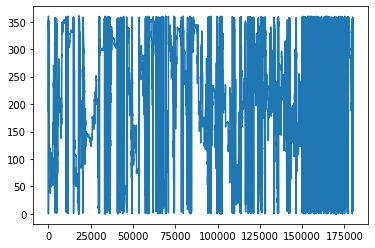

In [101]:
plt.plot(heading)

In [102]:
-10%360

350

(array([15737.,  8865., 12007., 13785., 16486., 14383., 14220., 13617.,
        28172., 42728.]),
 array([3.74061254e-03, 3.60021166e+01, 7.20004926e+01, 1.07998869e+02,
        1.43997245e+02, 1.79995620e+02, 2.15993996e+02, 2.51992372e+02,
        2.87990748e+02, 3.23989124e+02, 3.59987500e+02]),
 <BarContainer object of 10 artists>)

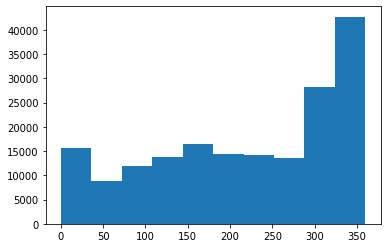

In [103]:
plt.hist(heading)

In [104]:
fictrac['h'][100]

340.91504025822775

In [105]:
fictrac['h'] = np.clip(fictrac['h'],0,360)

In [106]:
heading[100]
### The unit is in 10ms, so 1s = 100 (10ms)

340.91504025822775

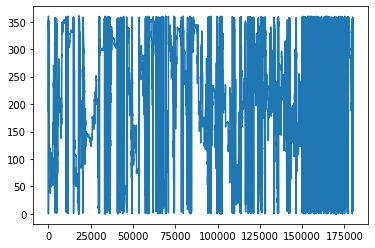

In [107]:
### Extract bar posoition over the 1800s
plt.plot(heading)

In [108]:
heading.shape

(180000,)

In [109]:
### Downsample the 100Hz fictrac data to 3384 neual data frame ###

In [110]:
timestamps = brainsss.load_timestamps(os.path.join(func_path, 'imaging'))
### 1. find the timestamps for neural data ###

Trying to load timestamp data from hdf5 file.
Success.


In [111]:
timestamps.shape

(3384, 49)

In [112]:
fictrac_timestamps = np.arange(0,1800000,10)

In [113]:
len(fictrac_timestamps)

180000

In [114]:
from scipy.interpolate import interp1d as interp1d

In [115]:
def interpolate_to_neural(slice_num, timestamps):
    x = timestamps[:, slice_num]
    f = interp1d(fictrac_timestamps, heading, fill_value="extrapolate") 
    ynew = f(x)
    return ynew

In [22]:
### Bin bar positions ###

In [26]:
### Neural data###
# n_clusters = 2000
# cluster_dir = os.path.join(func_path, 'clustering')

# load_file = os.path.join(cluster_dir, 'cluster_labels.npy')
# cluster_labels = np.load(load_file)

# load_file = os.path.join(cluster_dir, 'cluster_signals.npy')
# all_signals = np.load(load_file)

# def supervoxel_to_full_res(brain, cluster_labels):
#     n_clusters = brain.shape[1]
    
#     reformed_brain = []
#     for z in range(49):
#         colored_by_betas = np.zeros((256*128))
#         for cluster_num in range(n_clusters):
#             cluster_indicies = np.where(cluster_labels[z,:]==cluster_num)[0]
#             colored_by_betas[cluster_indicies] = brain[z,cluster_num]
#         colored_by_betas = colored_by_betas.reshape(256,128)
#         reformed_brain.append(colored_by_betas)
#     return np.asarray(reformed_brain)


In [116]:
neural_file = os.path.join(func_path, 'functional_channel_2_moco_zscore_highpass.h5') #
with h5py.File(neural_file, 'r') as h:
    print(h['data'].shape)
    neural = h['data'][:]

(256, 128, 49, 3384)


In [24]:
256*128

32768

In [69]:
neural.shape

(256, 128, 49, 3384)

In [26]:
slice_neural = neural[:,:,20,:]
slice_neural.shape

(256, 128, 3384)

In [26]:
indicies.shape

NameError: name 'indicies' is not defined

In [27]:
# neural = supervoxel_to_full_res(neural, cluster_labels)

In [27]:
whole_corr_reformed.shape

NameError: name 'whole_corr_reformed' is not defined

In [117]:
### Bin bar positions ###
bins = np.arange(-180,181,30)
#indicies = np.digitize(heading_interpolated,bins)
# this will return something like [0,2,3,2,2,1,3,1,3,2,2,1,2,3,2,2,2]
#

In [118]:
all_slices = []
for z in range(49):
    print(z)
    slice_neural = neural[:,:,z,:]
    
    heading_interpolated = interpolate_to_neural(z,timestamps)
    ### redefine 0
    heading_interpolated -= 180
    
    avg_neural_barposition = []
    bin_middle = []
    for i in range(len(bins)-1):
        start = bins[i]
        stop = bins[i+1]
        bin_middle.append((start+stop)/2)
        ids = np.where(np.logical_and(heading_interpolated>start, heading_interpolated<=stop))[0]
        avg_neural_barposition.append(np.mean(slice_neural[:,:,ids],axis=2))
    all_slices.append(np.asarray(avg_neural_barposition))
all_slices = np.asarray(all_slices)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


In [51]:
#bin_middle

In [119]:
avg_neural_barposition = []
bin_middle = []
for i in range(len(bins)-1):
    start = bins[i]
    stop = bins[i+1]
    bin_middle.append((start+stop)/2)
    ids = np.where(np.logical_and(heading_interpolated>start, heading_interpolated<=stop))[0]
    avg_neural_barposition.append(np.mean(slice_neural[:,:,ids],axis=2))

In [120]:
len(avg_neural_barposition)

12

In [121]:
np.arange(-180,180,30)

array([-180, -150, -120,  -90,  -60,  -30,    0,   30,   60,   90,  120,
        150])

In [122]:
len(avg_neural_barposition)

12

In [123]:
np.append((bins-18),(306+36))

array([-198, -168, -138, -108,  -78,  -48,  -18,   12,   42,   72,  102,
        132,  162,  342])

In [124]:
bin_middle

[-165.0,
 -135.0,
 -105.0,
 -75.0,
 -45.0,
 -15.0,
 15.0,
 45.0,
 75.0,
 105.0,
 135.0,
 165.0]

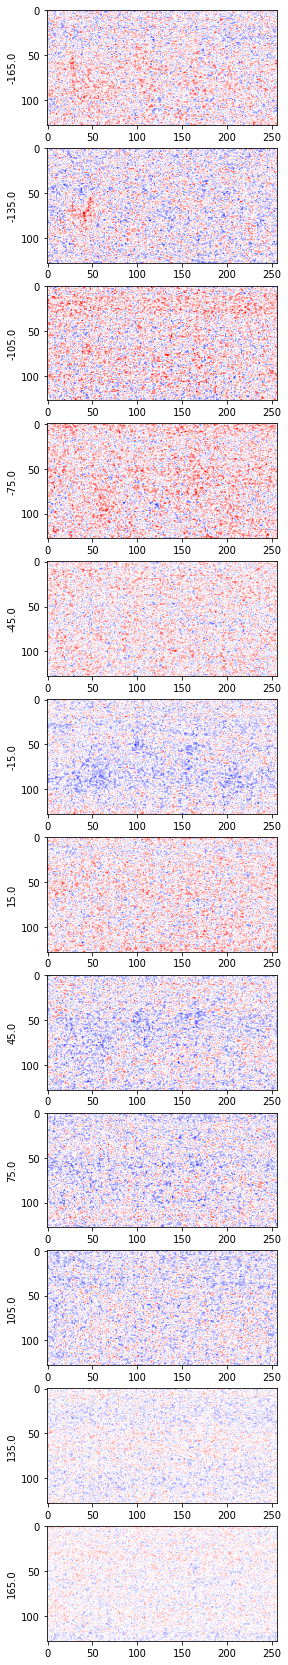

In [125]:
plt.figure(figsize=(10,30))
for i in range(len(avg_neural_barposition)):
    plt.subplot(12,1,i+1)
    plt.imshow(avg_neural_barposition[i].T,vmin=-0.5,vmax=0.5,cmap='seismic')
    plt.ylabel(bin_middle[i])

In [126]:
#STA_brain should be shape (12,256,128,49)

In [127]:
##EXPLODE
all_slices.shape

(49, 12, 256, 128)

In [128]:
all_slices = np.moveaxis(all_slices,0,3)
all_slices.shape

(12, 256, 128, 49)

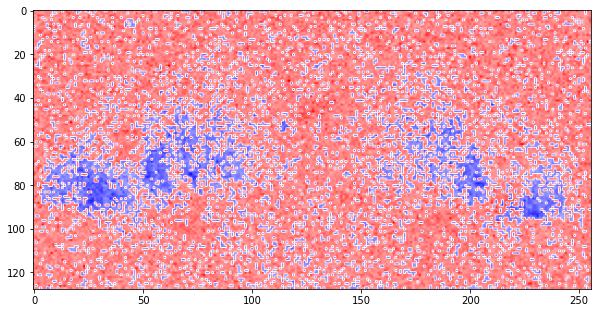

In [129]:
### max projection
### maximum projection along z-axis
# works for negative values
maxs = np.max(all_slices,axis=3)
mins = np.min(all_slices,axis=3)
maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
plt.figure(figsize=(10,10))
plt.imshow(maxs.T[:,:,6],cmap='seismic',vmin=-.7,vmax=.7)

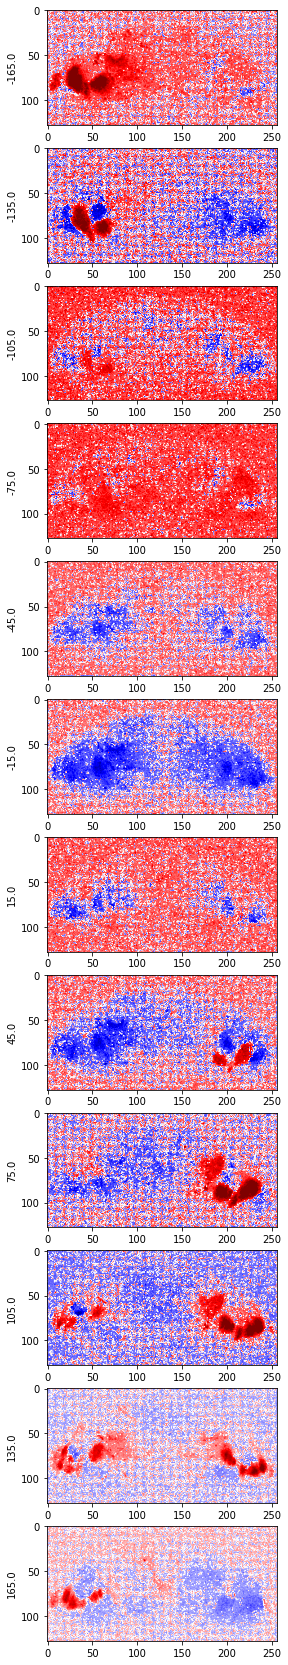

In [130]:
plt.figure(figsize=(10,30))
for i in range(len(maxs)):
    plt.subplot(12,1,i+1)
    plt.imshow(maxs[i].T,vmin=-0.5,vmax=0.5,cmap='seismic')
    plt.ylabel(bin_middle[i])

In [84]:
len(maxs)

12

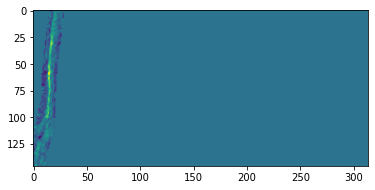

In [46]:
plt.imshow(warps[6][:,:,20].T)

In [131]:
fixed = brainsss.load_fda_meanbrain()
atlas = brainsss.load_roi_atlas()
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)

In [132]:
all_slices.shape

(12, 256, 128, 49)

In [133]:
warps = brainsss.warp_STA_brain(STA_brain=np.rollaxis(all_slices,3,0), fly='fly_311', fixed=fixed, anat_to_mean_type='myr')

In [134]:
np.shape(np.rollaxis(all_slices,3,0))

(49, 12, 256, 128)

In [135]:
len(warps)

12

In [136]:
explosions = []
t0 = time.time()
for angle in range(12):
    input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
    data_to_plot = warps[angle][:,:,::-1]
    vmax = 0.5
    explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                        roi_masks,
                                                        roi_contours,
                                                        data_to_plot,
                                                        input_canvas,
                                                        vmax=vmax,
                                                        cmap='seismic',
                                                        diverging=True)#'hot')
    explosions.append(explosion_map)

In [91]:
list(range(len(bin_middle)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [137]:
dataset_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_311'

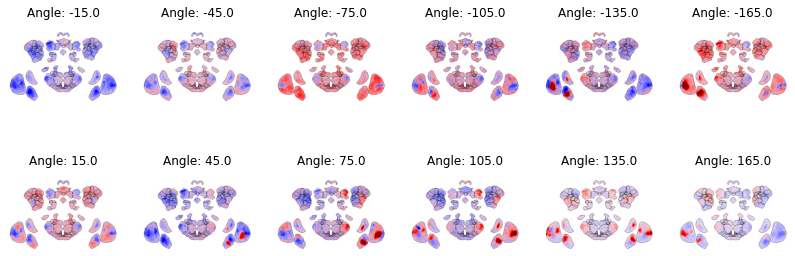

In [139]:
plt.figure(figsize=(14,5))

for k,i in enumerate([5, 4, 3, 2, 1, 0, 6, 7, 8, 9, 10, 11]):
    plt.subplot(2,6,k+1)
    plt.imshow(explosions[i][150:,:])
    plt.title(F"Angle: {bin_middle[i]}")
    plt.axis('off')
    
save_file = os.path.join(dataset_path, 'figs', '20230614')
plt.savefig(save_file,dpi=300,bbox_inches='tight',transparent=False)

In [50]:
warps[4].shape

(314, 146, 91)

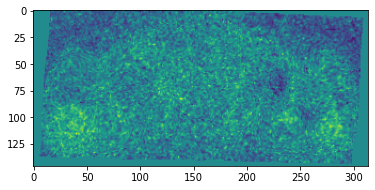

In [33]:
plt.imshow(warps[4][:,:,50].T)

In [52]:
all_slices.shape

(12, 256, 128, 49)

In [58]:
fly='fly_308'

In [140]:
moving_path = os.path.join(dataset_path, 'func_0', 'moco', 'functional_channel_1_moc_mean.nii')
func_mean = ants.image_read(moving_path)

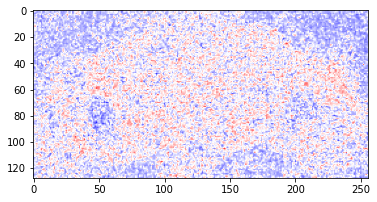

In [36]:
plt.imshow(all_slices[4,:,:,20].T,cmap='seismic',vmin=-.5,vmax=.5)

In [46]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [47]:
all_slices_norm = NormalizeData(all_slices)

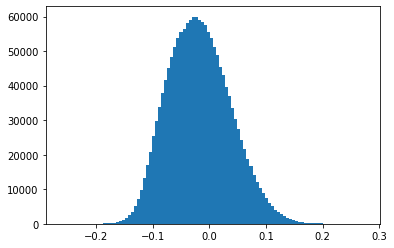

In [48]:
plt.hist(all_slices[4,:,:,:].flatten(),bins=100);

In [66]:
plt.hist(data_cmap[4,:,:,:].flatten(),bins=10);

NameError: name 'data_cmap' is not defined

In [49]:
cmap = plt.get_cmap('seismic')
data_cmap = cmap(all_slices[4,:,:,:]+.5)

In [50]:
data_cmap.shape

(256, 128, 49, 4)

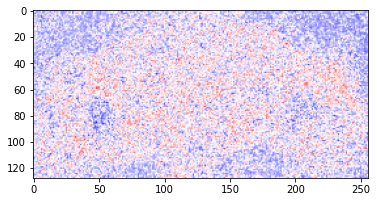

In [51]:
plt.imshow(np.swapaxes(data_cmap[:,:,20,:],0,1))

In [196]:

idx.shape

(256, 128, 49, 4)

In [64]:
all_slices.shape

(12, 256, 128, 49)

In [61]:
thresh = 0.2
data_cmap_thresh = data_cmap.copy()
idx = np.abs(data_cmap)<thresh
data_cmap_thresh[np.where(np.abs(data_cmap)<thresh)]
#out = np.reshape(out,(256,128,49,4))
#[:,:,:,3] = 0

array([0.12941176, 0.12941176, 0.19215686, ..., 0.14509804, 0.19215686,
       0.19215686])

In [62]:
data_cmap.shape

(256, 128, 49, 4)

In [72]:
(r,g,b,a)

NameError: name 'r' is not defined

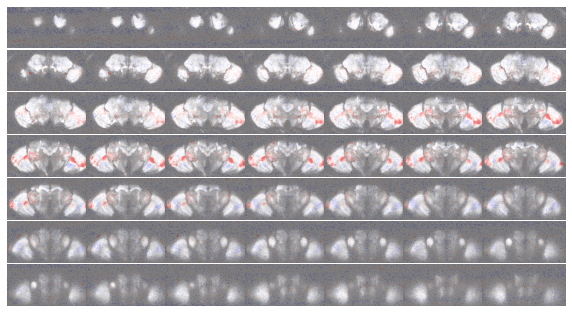

In [141]:
plt.figure(figsize=(10,10))
for z in range(49):
    plt.subplot(7,7,z+1)
    plt.imshow(func_mean[:,:,z].T,cmap='gray')
    plt.imshow(all_slices[10,:,:,z].T,cmap='seismic',vmin=-.5,vmax=.5,alpha=.5)
    plt.axis('off')
    
plt.subplots_adjust(hspace=-.85,wspace=-.05)
save_file = os.path.join(dataset_path, 'figs', '20230614_1')
plt.savefig(save_file,dpi=300,bbox_inches='tight',transparent=False)

In [38]:
slice_neural.shape

(256, 128, 3384)

In [39]:
slice_neural[:,:,272].shape

(256, 128)

# test warping

In [54]:
all_slices.shape

(12, 256, 128, 49)

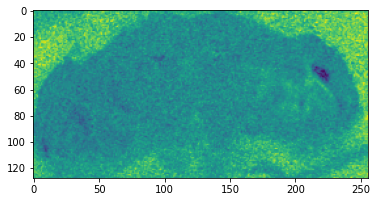

In [55]:
plt.imshow(all_slices[5,:,:,20].T)

In [56]:
moving = all_slices[5,:,:,:]
moving.shape

(256, 128, 49)

In [72]:
moving = ants.from_numpy(moving)
moving.set_spacing((2.611, 2.611, 5))

In [59]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/"
fly = "fly_262"
warp_directory = os.path.join(dataset_path, fly, 'warp')
warp_sub_dir = 'func-to-anat_fwdtransforms_2umiso'
affine_file = os.listdir(os.path.join(warp_directory, warp_sub_dir))[0]
affine_path = os.path.join(warp_directory, warp_sub_dir, affine_file)
warp_sub_dir = 'anat-to-meanbrain_fwdtransforms_2umiso'

In [83]:
syn_files = os.listdir(os.path.join(warp_directory, warp_sub_dir))
syn_linear_path = os.path.join(warp_directory, warp_sub_dir, [x for x in syn_files if '.mat' in x][0])
syn_nonlinear_path = os.path.join(warp_directory, warp_sub_dir, [x for x in syn_files if '.nii.gz' in x][0])
####transforms = [affine_path, syn_linear_path, syn_nonlinear_path]
transforms = [syn_nonlinear_path, syn_linear_path, affine_path]

In [84]:
transforms

['/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_262/warp/anat-to-meanbrain_fwdtransforms_2umiso/tmprb1m3hhe1Warp.nii.gz',
 '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_262/warp/anat-to-meanbrain_fwdtransforms_2umiso/tmprb1m3hhe0GenericAffine.mat',
 '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_262/warp/func-to-anat_fwdtransforms_2umiso/tmpo1fh43lu0GenericAffine.mat']

In [85]:
fixed = brainsss.load_fda_meanbrain()

In [61]:
fixed_path = os.path.join(dataset_path, fly, 'anat_0', 'moco', 'anatomy_channel_1_moc_mean.nii')
fixed = ants.image_read(fixed_path)

In [69]:
fixed.set_spacing((0.653, 0.653, 1))

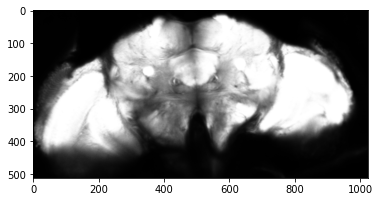

In [67]:
plt.imshow(fixed[:,:,100].T,cmap='gray')

In [ ]:
res_anat = (0.653, 0.653, 1)
res_func = (2.611, 2.611, 5)

In [73]:
transforms = affine_path

In [87]:
moco = ants.apply_transforms(fixed, moving, transforms)

In [88]:
moco

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (314, 146, 91)
	 Spacing    : (2.0, 2.0, 2.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

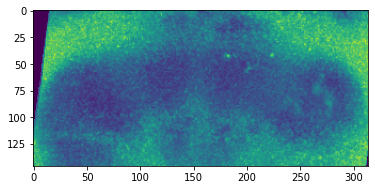

In [89]:
plt.imshow(np.max(moco.numpy(),axis=2).T)